<a href="https://colab.research.google.com/github/Stroper-Flame/TPLN-Proyecto-Final/blob/main/Proyecto_NLP_OffendES_V3_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación de librerías para NLP y Transformers
#Solo para colab
!pip install accelerate scikit-learn pandas matplotlib seaborn

In [ ]:
import pandas as pd

# URLs directas a los archivos RAW del repositorio
url_train = 'https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/training_set.tsv'

# Cargamos directamente desde la URL
# Usamos sep='\t' por ser un documento .tsv
try:
    df_train = pd.read_csv(url_train, sep='\t')
    print(df_train.head())

except Exception as e:
    print("Ocurrio un error", e)

   comment_id                                            comment  \
0       52564  En vez de la magia de mi melena, la magia de m...   
1       32984  A ver, los milenials y la gente normal necesit...   
2       58447  Me encanta todo el contenido que haces se nota...   
3       10341  a Laura sige así que vales mucho más que 10 o ...   
4       53087  Y si no mes gusta Dalas, que hacen aquí,lárgue...   

       influencer influencer_gender      media label  
0           dalas               man  instagram    NO  
1  soyunapringada             woman    youtube    NO  
2       wildhater               man  instagram    NO  
3     lauraescane             woman    youtube    NO  
4           dalas               man  instagram    NO  


Conteo de cada etiqueta:
label
NO     13212
OFP     2051
NOE     1235
OFG      212
Name: count, dtype: int64


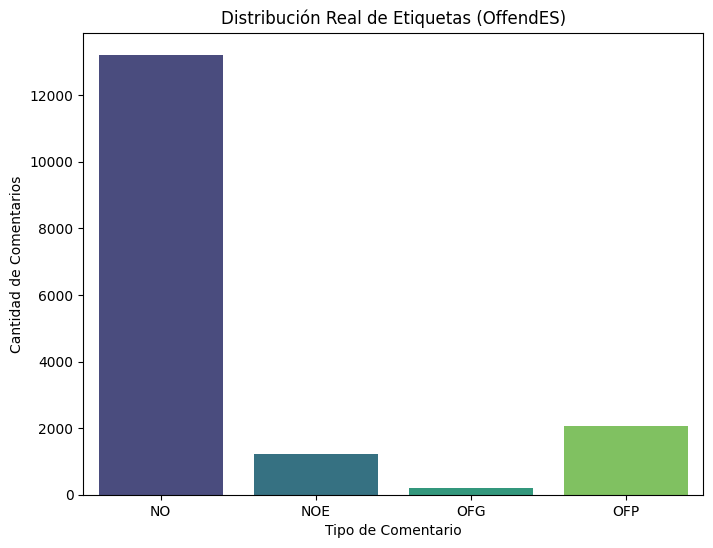

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Primero veremos los números exactos en texto
print("Conteo de cada etiqueta:")
print(df_train['label'].value_counts())

# La gráfica corregida
plt.figure(figsize=(8, 6))

# Usamos hue='label' y legend=False para evitar el warning de Seaborn que nos salía
sns.countplot(x='label', data=df_train, hue='label', legend=False, palette='viridis')

plt.title('Distribución Real de Etiquetas (OffendES)')
plt.ylabel('Cantidad de Comentarios')
plt.xlabel('Tipo de Comentario')
plt.show()

In [ ]:
#Se eligió dejar los emojis porque nos pueden dar más contexto de los comentarios
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.8 MB/s eta 0:00:00


In [ ]:
import emoji
import re

def clean_text_smart(text):
    # nos aseguramos que es string
    text = str(text)

    # Convertimos los emojis a texto explicativo
    # El parámetro delimiters define qué poner alrededor, usamos espacios para separar bien
    text = emoji.demojize(text, language='es', delimiters=(" ", " "))

    #Convertimos a minúsculas
    text = text.lower()

    # Eliminar URLs, menciones y hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Limpieza de caracteres:
    # Ahora si permitimos guiones bajos (_) porque los emojis demojizados los usan
    # Mantenemos letras, números, espacios, tildes y guion bajo.
    text = re.sub(r'[^a-záéíóúñ0-9\s_]', '', text)

    #Quitamos espacios extra
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicamos la nueva limpieza
df_train['comment_clean'] = df_train['comment'].apply(clean_text_smart)

# Veamos la diferencia
print("\nEjemplos para visualizar:")
# Buscamos un ejemplo que tenga emojis para ver si funcionó
ejemplo_con_emoji = df_train[df_train['comment'].str.contains(r'[^\w\s,.!]', regex=True)].head(1)
print(ejemplo_con_emoji[['comment', 'comment_clean']].values)


Ejemplos para visualizar:
[['Me encanta todo el contenido que haces se nota que te curras mucho los videos y que te gusta lo que haces. Sigue asi que eres un crack👏👏 y gracias por todo😘😘😘💙💙💙🔥🔥🔥🔥'
  'me encanta todo el contenido que haces se nota que te curras mucho los videos y que te gusta lo que haces sigue asi que eres un crack manos_aplaudiendo manos_aplaudiendo y gracias por todo cara_lanzando_un_beso cara_lanzando_un_beso cara_lanzando_un_beso corazón_azul corazón_azul corazón_azul fuego fuego fuego fuego']]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Cargar los 3 datasets CORRECTOS desde GitHub
url_train = 'https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/training_set.tsv'
url_dev = 'https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/dev_set.tsv'
url_test = 'https://raw.githubusercontent.com/fmplaza/OffendES/main/split_MeOffendES/test_set.tsv'

df_train = pd.read_csv(url_train, sep='\t')
df_dev = pd.read_csv(url_dev, sep='\t')
df_test = pd.read_csv(url_test, sep='\t')

print(f"Dimensiones cargadas -> Train: {df_train.shape}, Dev: {df_dev.shape}, Test: {df_test.shape}")

#Preprocesamiento
binary_mapping = {'NO': 0, 'NOE': 0, 'OFP': 1, 'OFG': 1}

# Aplicar mapeo a los 3 sets
df_train['label_binary'] = df_train['label'].map(binary_mapping)
df_dev['label_binary'] = df_dev['label'].map(binary_mapping)
df_test['label_binary'] = df_test['label'].map(binary_mapping)

# Aplicar limpieza
df_train['comment_clean'] = df_train['comment'].apply(clean_text_smart)
df_dev['comment_clean'] = df_dev['comment'].apply(clean_text_smart)
df_test['comment_clean'] = df_test['comment'].apply(clean_text_smart)

# Vectorización (TF-IDF)
# Creamos el vectorizador
#vectorizer = TfidfVectorizer(max_features=5000, min_df=2)
vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # Lee palabras individuales Y pares

# Definimos X e y para todos los sets
X_train_text = df_train['comment_clean']
y_train = df_train['label_binary']
X_dev_text = df_dev['comment_clean']
y_dev = df_dev['label_binary']
X_test_text = df_test['comment_clean']
y_test = df_test['label_binary']

# FIT solo en TRAIN, Usamos Transform en los demás
X_train = vectorizer.fit_transform(X_train_text)
X_dev = vectorizer.transform(X_dev_text)   #Solo transform
X_test = vectorizer.transform(X_test_text)
print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape:   {X_dev.shape}")
print(f"X_test shape:  {X_test.shape}")

Dimensiones cargadas -> Train: (16710, 6), Dev: (100, 6), Test: (13606, 6)
X_train shape: (16710, 257557)
X_dev shape:   (100, 257557)
X_test shape:  (13606, 257557)


              precision    recall  f1-score   support

 No Ofensivo       0.91      0.93      0.92     11055
    Ofensivo       0.69      0.62      0.65      2551

    accuracy                           0.88     13606
   macro avg       0.80      0.78      0.79     13606
weighted avg       0.87      0.88      0.87     13606



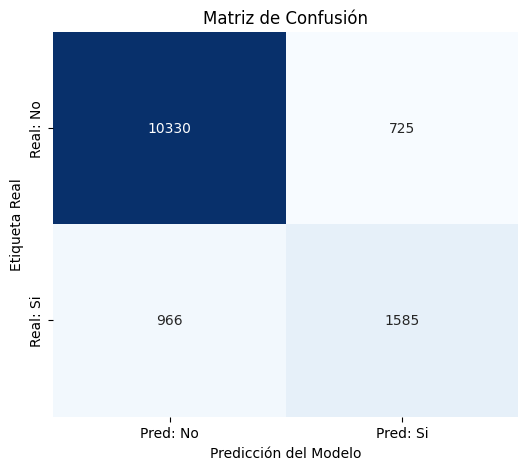

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Creación el modelo
# class_weight='balanced' es necesario por el desbalance de clases
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Entrenar (Fit) con los datos de entrenamiento
model.fit(X_train, y_train)

# Predecir (Predict) con los datos de prueba
y_pred = model.predict(X_test)

# Evaluación de resultados
# Esto nos dará Precision, Recall y F1-Score (mejores que el Accuracy simple)
print(classification_report(y_test, y_pred, target_names=['No Ofensivo', 'Ofensivo']))

# Creamos la matriz de Confusión Gráfica
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: No', 'Pred: Si'],
            yticklabels=['Real: No', 'Real: Si'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Dado que el SVM base no superó a la Regresión Logística,
# procedemos a buscar matemáticamente el mejor valor de 'C' (regularización)
# para maximizar el rendimiento.

print("Búsqueda de hiperparámetros")

# Definimos la rejilla de valores a probar
# C pequeños = Más regularización (modelo más simple)
# C grandes = Menos regularización (se intenta ajustar más los datos)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Configuramos el GridSearch
# scoring='f1_macro': Buscamos el mejor equilibrio general
grid = GridSearchCV(LinearSVC(class_weight='balanced', random_state=42, max_iter=3000),
                    param_grid,
                    refit=True,
                    verbose=2,
                    scoring='f1_macro', # Optimizamos para F1-Score promedio
                    n_jobs=-1) # Usar todos los núcleos del procesador

# Entrenar con todas las combinaciones
grid.fit(X_train, y_train)

print(f"\nMejor configuración encontrada: {grid.best_params_}")

# Probamos el mejor modelo en el Test Set
best_model = grid.best_estimator_
y_pred_opt = best_model.predict(X_test)

print(classification_report(y_test, y_pred_opt, target_names=['No Ofensivo', 'Ofensivo']))

Búsqueda de hiperparámetros
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Mejor configuración encontrada: {'C': 0.1}
              precision    recall  f1-score   support

 No Ofensivo       0.91      0.94      0.92     11055
    Ofensivo       0.69      0.62      0.65      2551

    accuracy                           0.88     13606
   macro avg       0.80      0.78      0.79     13606
weighted avg       0.87      0.88      0.87     13606



In [ ]:
def predecir_frase(frase, modelo, vectorizador):
    #Limpiar la frase igual que en el entrenamiento
    frase_clean = clean_text_smart(frase)

    # Vectorizar
    frase_vect = vectorizador.transform([frase_clean])

    #Predecir
    prediccion = modelo.predict(frase_vect)[0]
    probabilidad = "N/A" # Recordemos que LinearSVC no da probabilidades directas fácilmente, solo clases

    etiqueta = "OFENSIVO" if prediccion == 1 else "No Ofensivo"

    print(f"Frase: '{frase}'")
    print(f"Limpieza: '{frase_clean}'")
    print(f"Resultado: {etiqueta}\n")
    return prediccion

# zona de pruebas
# Frases para probar
frases_prueba = [
    "Me das cringe",
    "Jaja que manco",
    "Eres un niño 🐭",
    "La perra de mi primo tuvo bebés",
    "No eres tonta",
]

print("Pruebas del modelo\n")
for f in frases_prueba:
    predecir_frase(f, best_model, vectorizer)

Pruebas del modelo

Frase: 'Me das cringe'
Limpieza: 'me das cringe'
Resultado: OFENSIVO

Frase: 'Jaja que manco'
Limpieza: 'jaja que manco'
Resultado: No Ofensivo

Frase: 'Eres un niño 🐭'
Limpieza: 'eres un niño cara_de_ratón'
Resultado: OFENSIVO

Frase: 'La perra de mi primo tuvo bebés'
Limpieza: 'la perra de mi primo tuvo bebés'
Resultado: OFENSIVO

Frase: 'No eres tonta'
Limpieza: 'no eres tonta'
Resultado: OFENSIVO



In [ ]:
# Zona de pruebas en vivo

print("Escribe una frase para analizar o escribe 'salir' para terminar.\n")

while True:
    # Solicitamos entrada al usuario
    user_input = input("Ingresa tu frase: ")

    # Condición de salida
    if user_input.lower() in ['salir']:
        break

    if user_input.strip():
        print(f"   Analizando: '{user_input}'")
        prediccion = predecir_frase(user_input, best_model, vectorizer)
        print("-" * 50)

Escribe una frase para analizar o escribe 'salir' para terminar.

Ingresa tu frase: dalas
   Analizando: 'dalas'
Frase: 'dalas'
Limpieza: 'dalas'
Resultado: No Ofensivo

--------------------------------------------------
Ingresa tu frase: eres bueno dalas
   Analizando: 'eres bueno dalas'
Frase: 'eres bueno dalas'
Limpieza: 'eres bueno dalas'
Resultado: OFENSIVO

--------------------------------------------------


KeyboardInterrupt: Interrupted by user